In [3]:
from datasets import load_dataset

dataset = load_dataset("Naveengo/flickr8k")
dataset = dataset['train']


Generating train split: 100%|██████████| 8091/8091 [00:01<00:00, 4144.87 examples/s]


In [8]:
print(dataset)

Dataset({
    features: ['image', 'text'],
    num_rows: 8091
})


In [9]:
from PIL import Image

img = dataset[0]["image"]

if isinstance(img, Image.Image):  
    img = np.array(img)  # Chuyển sang NumPy array
elif hasattr(img, 'numpy'):
    img = img.numpy()  # Nếu là Tensor thì chuyển sang NumPy

plt.imshow(img)
plt.axis('off')
plt.show()

AttributeError: module 'PIL.Image' has no attribute 'ExifTags'

A man in a checked shirt stands next to a large wooden bowl .


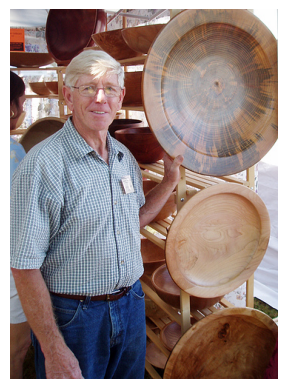

In [6]:
import matplotlib.pyplot as plt
import numpy as np

caption= dataset[800]["text"]
img= dataset[800]["image"]
print(caption)
plt.imshow(img)
plt.axis('off')
plt.show()

## Create PyTorch Dataset

In [10]:
from torch.utils.data import Dataset, DataLoader, random_split

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt", max_length=128)
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding, item["text"]

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [13]:
model

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [14]:
train_dataset = ImageCaptioningDataset(dataset, processor)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_subset, shuffle=True, batch_size=2)
val_dataloader = DataLoader(val_subset, shuffle=True, batch_size=2)
print("Train:",len(train_subset))
print("Val:",len(val_subset))

Train: 7281
Val: 810


## Train the model

In [18]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch[0].pop("input_ids").to(device)
        pixel_values = batch[0].pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    if (idx % 200 == 0) or (idx % (len(train_dataloader)-1) == 0):
        print(f"Epoch: {epoch}, Batch: {idx}/{len(train_dataloader)}, Loss: {loss.item()}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0, Batch: 3640/3641, Loss: 0.1486583799123764
Epoch: 1, Batch: 3640/3641, Loss: 0.09857717901468277
Epoch: 2, Batch: 3640/3641, Loss: 0.17809227108955383
Epoch: 3, Batch: 3640/3641, Loss: 0.056736186146736145
Epoch: 4, Batch: 3640/3641, Loss: 0.060026444494724274
Epoch: 5, Batch: 3640/3641, Loss: 0.04687683284282684
Epoch: 6, Batch: 3640/3641, Loss: 0.03724592551589012
Epoch: 7, Batch: 3640/3641, Loss: 0.051258835941553116
Epoch: 8, Batch: 3640/3641, Loss: 0.003109976416453719
Epoch: 9, Batch: 3640/3641, Loss: 0.012708445079624653


In [ ]:
model_save_path = "./saved_model"
model.save_pretrained(model_save_path, from_pt=True)

In [18]:
import zipfile
import os
zip_filename = "finetuned_modelBLIP.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(model_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(model_save_path, '..')))

print(f"Saved trained model to {zip_filename}")

Saved trained model to finetuned_modelBLIP.zip


## Inference

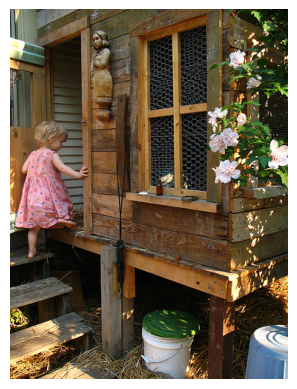

a little girl in a pink dress


In [20]:
example = dataset[0]
image = example["image"]
plt.imshow(image)
plt.axis('off')
plt.show()
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Generated caption: a man and a little girl playing in a pool
True caption: "A girl jumping into a pool   with a man standing near ."


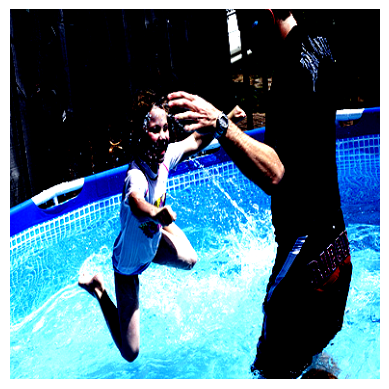

Generated caption: a man sitting on a bench reading a book
True caption: A man in a hat and sunglasses reads a book on a park bench .


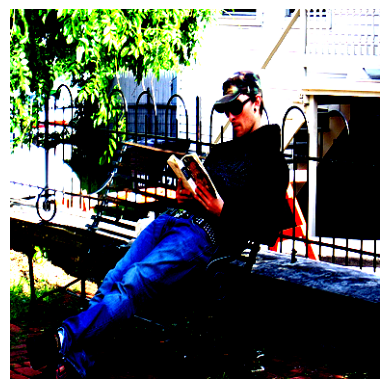

Generated caption: a man is rapping through a waterfall
True caption: A man belaying down a waterfall


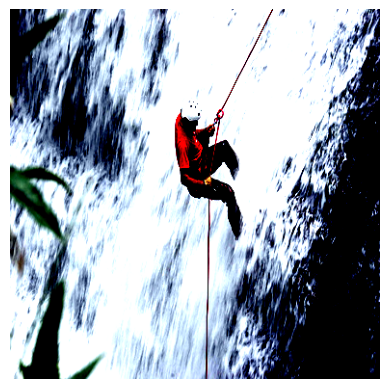

In [23]:
from matplotlib import pyplot as plt
from PIL import Image

for _ in range(3):
    batch = next(iter(val_dataloader))
    input_ids = batch[0].pop("input_ids")
    pixel_values = batch[0].pop("pixel_values")

    image = pixel_values[0].cpu().permute(1, 2, 0).numpy()

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    generated_caption=generated_caption.replace(' - ', '-')
    print(f"Generated caption: {generated_caption}")
    print(f"True caption: {batch[1][0]}")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Bleu Score

In [24]:
!pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [25]:
print("Length val_dataloader:",len(val_dataloader))

Length val_dataloader: 405


In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import evaluate

references = []
generated_captions = []

for i, batch in enumerate(val_dataloader):
    input_ids = batch[0].pop("input_ids")
    pixel_values = batch[0].pop("pixel_values")

    image = pixel_values[0].cpu().permute(1, 2, 0).numpy()

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    generated_caption=generated_caption.replace(' - ', '-')
    generated_captions.append(generated_caption)

    reference_caption = batch[1]
    references.append(reference_caption)

bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=generated_captions, references=references)

print(f"BLEU-4 Score: {bleu_score}")